In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Import file

In [6]:
data = pd.read_csv('diabetes_prediction_dataset.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


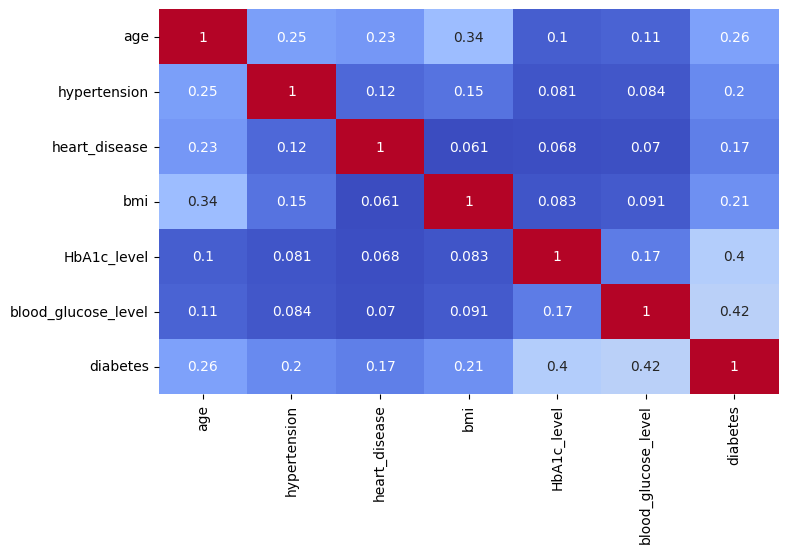

In [7]:
num_cols = [col for col in data.columns if data[col].dtype != 'O']
plt.figure(figsize=(8,5))
sns.heatmap(data[num_cols].corr(),cmap='coolwarm',annot=True,cbar=False)
plt.show()

In [8]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

###  EDA on Data 

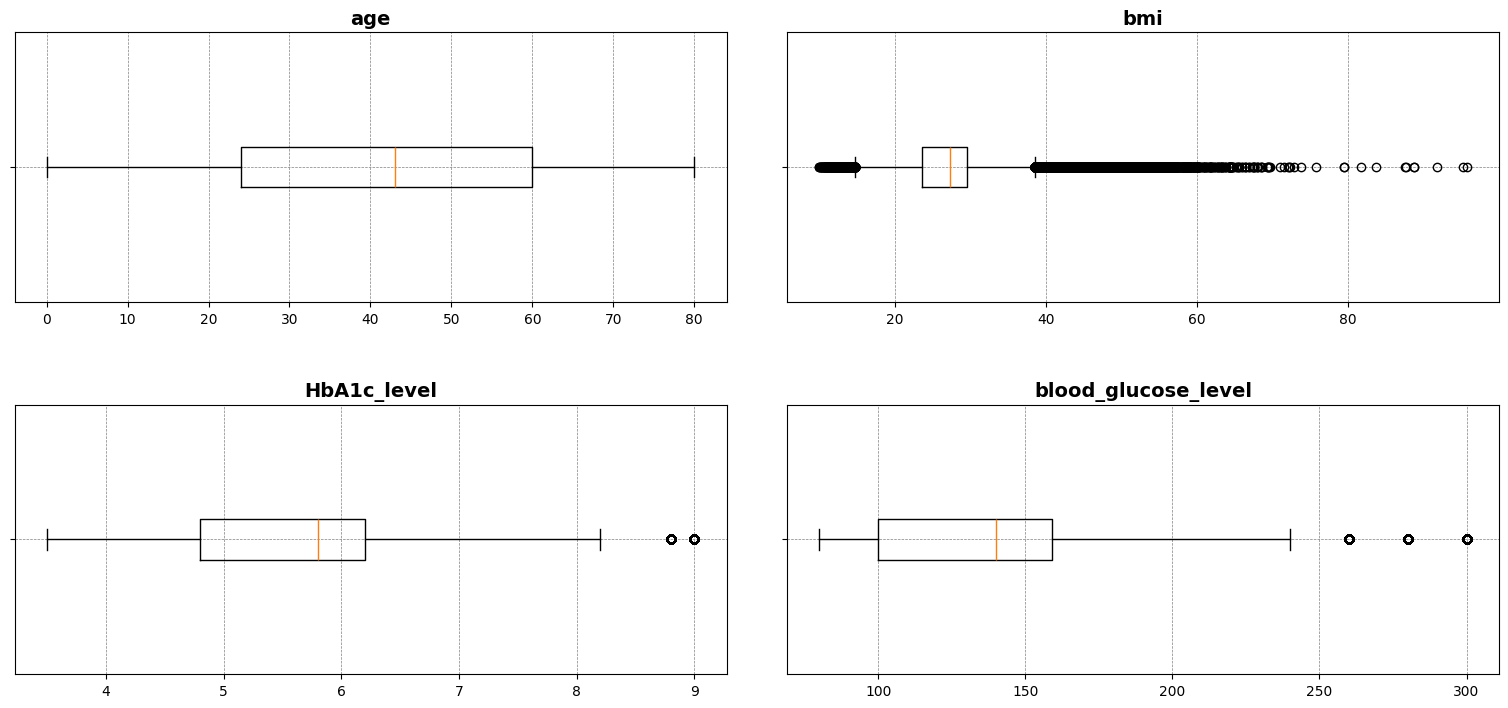

In [9]:
num_cols = [col for col in data.columns[:-1] if (data[col].dtype != 'O') & (col not in ['hypertension','heart_disease'])]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ax = ax.flatten()
boxplot_color = 'steelblue'
for i, col in enumerate(num_cols):
    bp = ax[i].boxplot(data[col], vert=False)
    ax[i].set_title(col, fontsize=14, fontweight='bold')
    ax[i].grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
    ax[i].set_yticklabels([])
plt.tight_layout(pad=4.0)
plt.show()

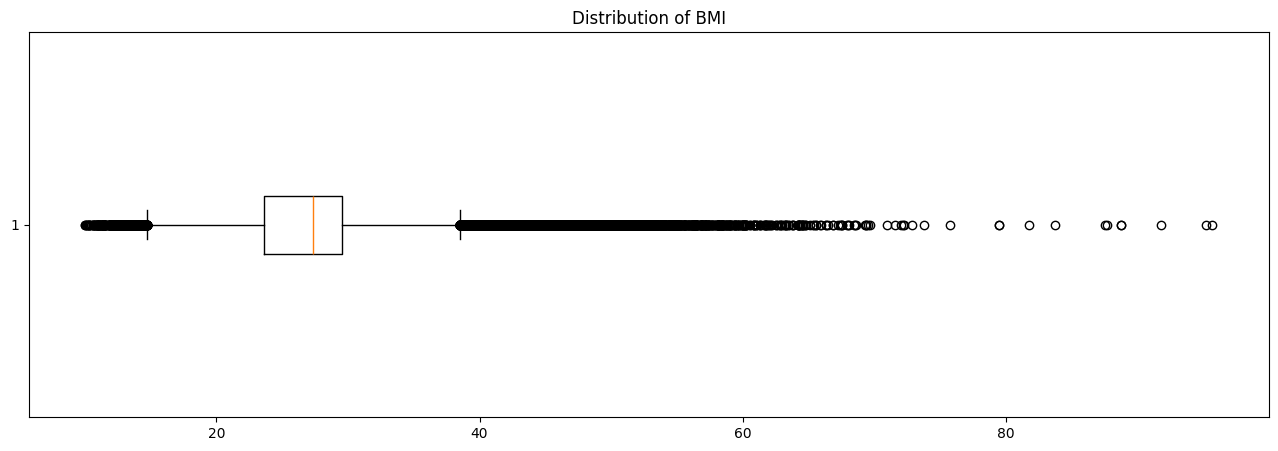

In [10]:
plt.figure(figsize=(16,5))
plt.boxplot(data['bmi'],vert=False)
plt.title("Distribution of BMI")
plt.show()

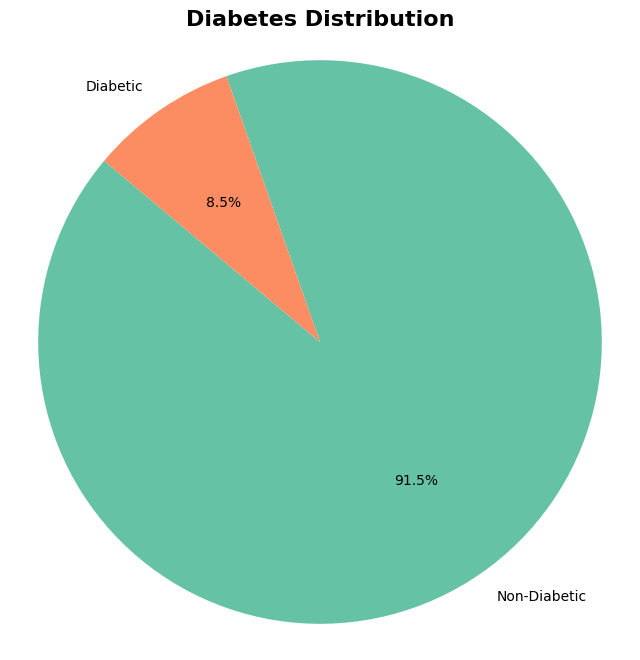

In [11]:
diabetes_counts = data['diabetes'].value_counts()

plt.figure(figsize=(8, 8)) 
plt.pie(diabetes_counts, labels=['Non-Diabetic','Diabetic'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Diabetes Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

## Feature Engineering (Age Groups)

In [12]:
data['age_groups'] = pd.cut(data['age'],bins = [0,12,19,29,39,54,64,float('inf')],labels = ['child','teenager','young adult','adult','midle aged','old','senior']).astype('O')

## Feature Engineering (BMI Groups)

In [13]:
data['bmi_groups'] = pd.cut(data['bmi'],bins = [0,18.4,24.9,29.9,float('inf')],labels = ['under weight','normal','overweight','obese']).astype('O')

In [14]:
data.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_groups,bmi_groups
0,Female,80.0,0,1,never,25.19,6.6,140,0,senior,overweight
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,midle aged,overweight
2,Male,28.0,0,0,never,27.32,5.7,158,0,young adult,overweight
3,Female,36.0,0,0,current,23.45,5.0,155,0,adult,normal
4,Male,76.0,1,1,current,20.14,4.8,155,0,senior,normal


## Feature Engineering (Interaction Features)

In [15]:
data['HH'] = ((data['hypertension'] == 1) & (data['heart_disease'] == 1)).astype(int)
data['AH'] = data['age'] * data['hypertension']
data['AHD'] = data['age'] * data['heart_disease']
data['BB'] = data['blood_glucose_level'] * data['bmi']

### Encoding categoricial Features

In [16]:
data['gender'] = np.where(data['gender'].str.lower() == 'female', 0, 1)
data = pd.get_dummies(data=data,columns=['smoking_history','age_groups','bmi_groups'],drop_first=True,dtype=int)
data.head() 

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,HH,AH,...,smoking_history_not current,age_groups_child,age_groups_midle aged,age_groups_old,age_groups_senior,age_groups_teenager,age_groups_young adult,bmi_groups_obese,bmi_groups_overweight,bmi_groups_under weight
0,0,80.0,0,1,25.19,6.6,140,0,0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,0,54.0,0,0,27.32,6.6,80,0,0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,1,28.0,0,0,27.32,5.7,158,0,0,0.0,...,0,0,0,0,0,0,1,0,1,0
3,0,36.0,0,0,23.45,5.0,155,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,76.0,1,1,20.14,4.8,155,0,1,76.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
#Reduce features for application to top seven





## Model Code

In [17]:
#pip install lightgbm

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
import lightgbm as lgb
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_test, y_scores):
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_scores))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def print_metrics(model, X_train, X_test, y_train, y_test):    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1] # Scores for ROC curve
    
    print(f"Training Accuracy Score: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Test Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Test F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"Test ROC AUC Score: {roc_auc_score(y_test, y_scores):.4f}")
    
    plot_cm(y_test, y_pred)
    plot_roc_curve(y_test, y_scores)

def fit_model(model, X, y, standardize=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    if standardize:
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    model.fit(X_train, y_train)
    print_metrics(model, X_train, X_test, y_train, y_test)
    return model

In [22]:
X = data.drop(['diabetes'],axis=1).values
y = data['diabetes'].values

## Light GBM Model 

[LightGBM] [Info] Number of positive: 5953, number of negative: 64047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training Accuracy Score: 0.9217
Test Accuracy Score: 0.9156
Test F1 Score: 0.6467
Test ROC AUC Score: 0.9790


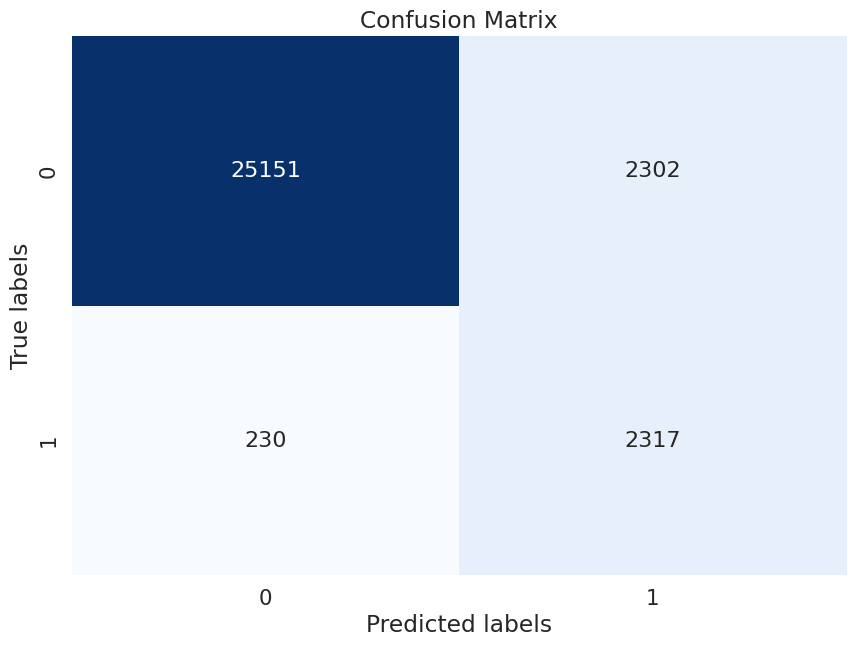

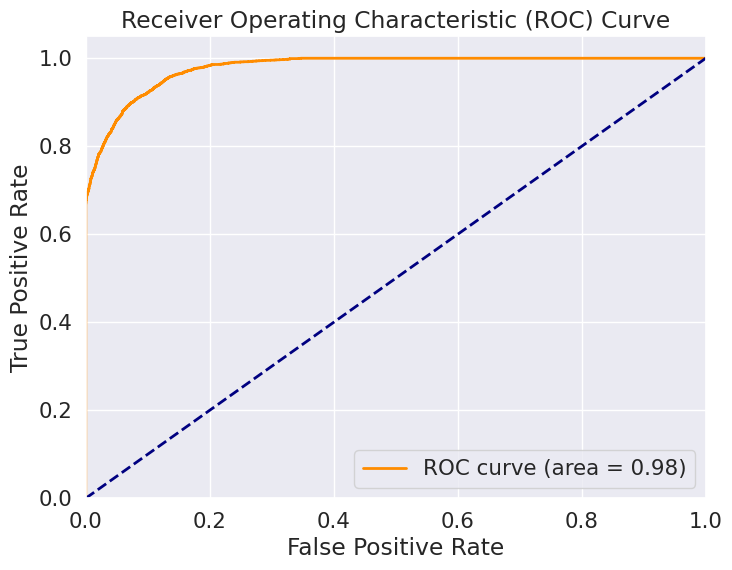

In [23]:
# Assuming X and y are defined and represent your features and target variable respectively
lgbm_clf = lgb.LGBMClassifier(class_weight='balanced')
lgbm_clf = fit_model(lgbm_clf, X, y)

## Random Forrest


Training Accuracy Score: 0.9992
Test Accuracy Score: 0.9695
Test F1 Score: 0.7914
Test ROC AUC Score: 0.9655


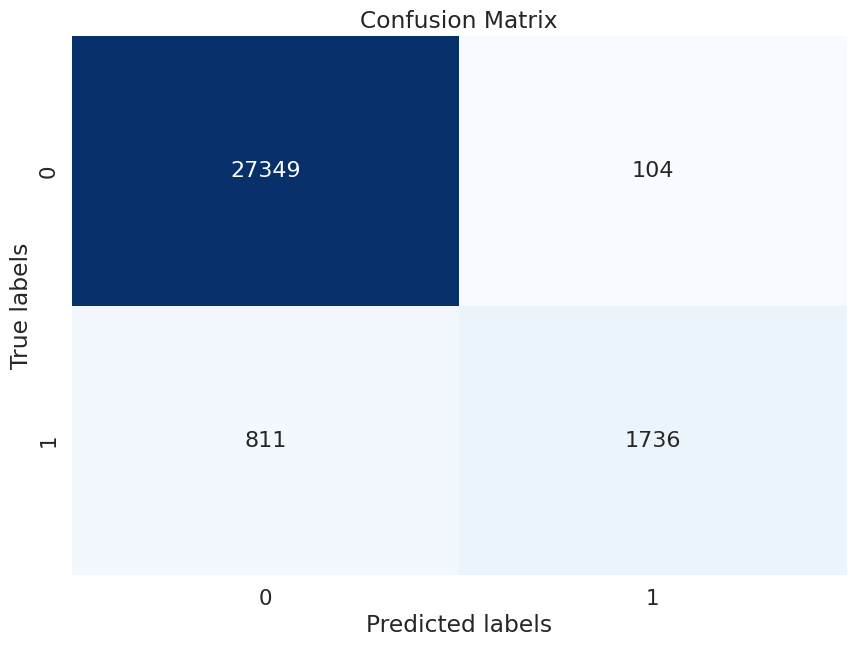

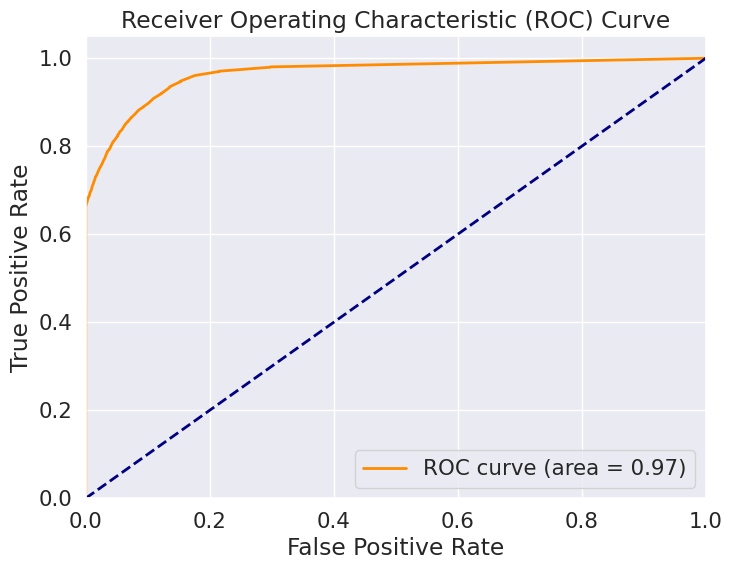

In [27]:
# Create a Random Forest Classifier with balanced class weights
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model on your data
rf_clf = fit_model(rf_clf, X, y)

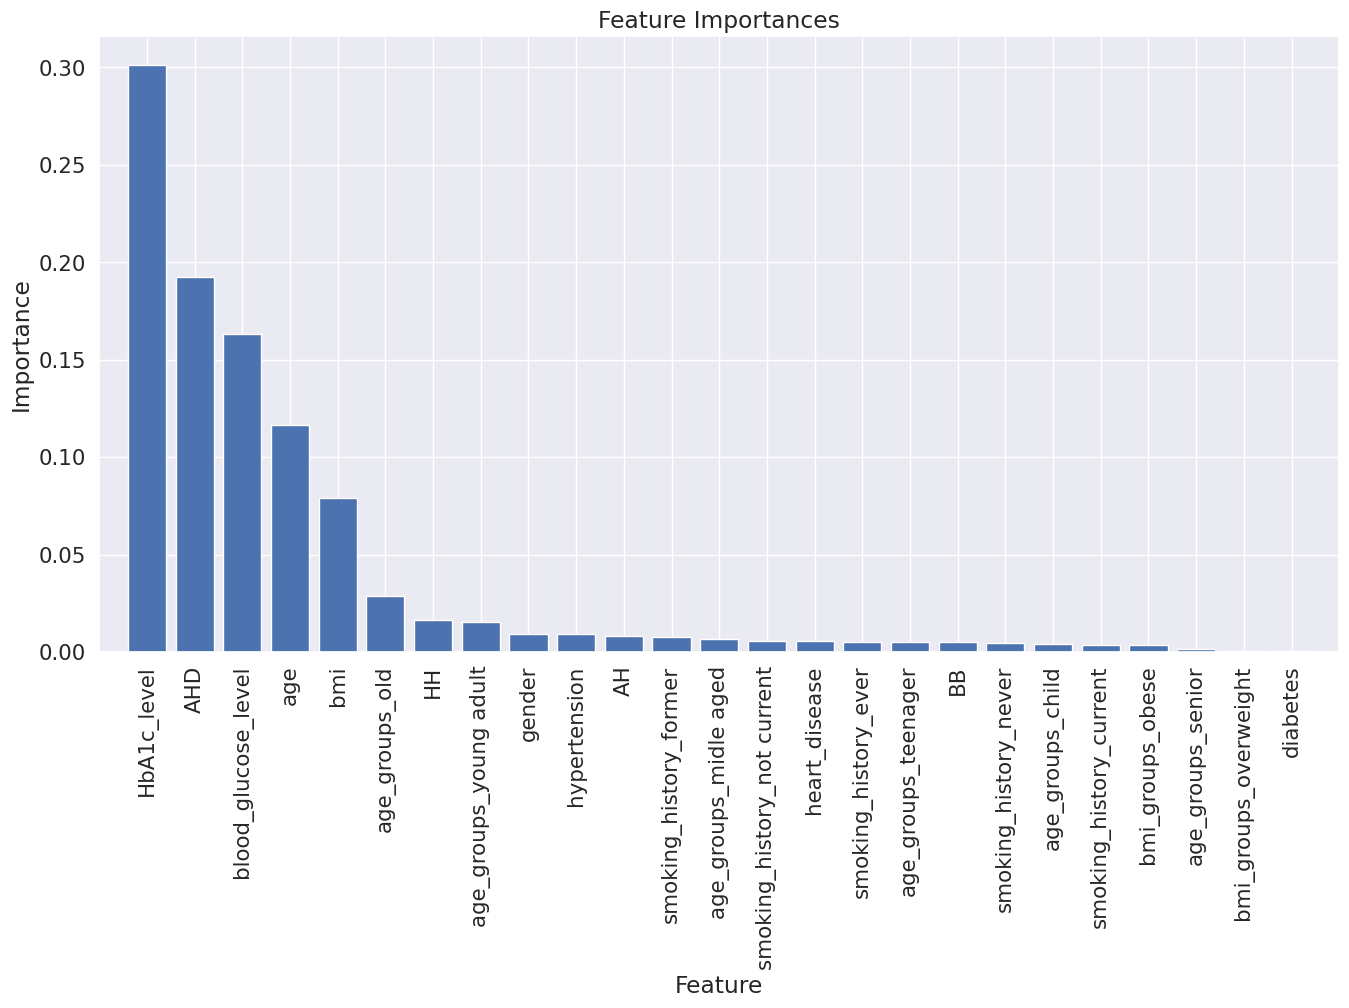

In [29]:
# Assuming rf_clf is your trained Random Forest model and data is your dataset
feature_names = data.columns[:-1]  # This is your feature names, assumed to be correctly assigned as before

# Get feature importances from the model
feature_importances = rf_clf.feature_importances_

# Sort the feature importances in descending order for better visualization
sorted_idx = np.argsort(feature_importances)[::-1]

# Plotting
plt.figure(figsize=(16, 8))
plt.title('Feature Importances')
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlim([-1, len(sorted_idx)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [30]:
import pickle

# Save the model to a file
filename = 'finalized_model.sav'
pickle.dump(lgbm_clf, open(filename, 'wb'))